In [1]:
import jsonlines
import numpy as np
import pandas as pd
from typing import Tuple
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
DATA_DIR = "/home/welton/data"
PROBS_DIR = f"{DATA_DIR}/normal_probas/split_10"
LABELS_DIR = f"{DATA_DIR}/datasets/labels/split_10"
LABELS_DIR_VAL = f"{DATA_DIR}/datasets/labels/split_10_with_val/"
UPPER_DIR = f"{DATA_DIR}/oracle/upper_bound/normal_probas"
STACKING_DIR = f"{DATA_DIR}/stacking/stacking_output"
CLFS = ["bert", "xlnet", "ktmk", "ktr", "lstmk", "lstr", "ltr"]
N_FOLDS = 10

In [3]:
clfs_stack = '/'.join(sorted([f"{clf}_normal_probas" for clf in CLFS ]))
clfs_stack

'bert_normal_probas/ktmk_normal_probas/ktr_normal_probas/lstmk_normal_probas/lstr_normal_probas/ltr_normal_probas/xlnet_normal_probas'

In [4]:
def get_cdf(values):

    counts = pd.Series(values).value_counts()
    keys = list(counts.keys())
    keys.sort()
    total = values.shape[0]
    cdf = []
    acc = 0
    for key in keys:
        acc += counts[key] / total
        cdf.append(acc)
    return keys, cdf

def load_probs(probs_source: str,
               dataset: str,
               clfs: list,
               fold: int):

    probas = {}
    for clf in clfs:
        probas[clf] = {}
        probas_dir = f"{probs_source}/{dataset}/10_folds/{clf}/{fold}/"
        train_load = np.load(f"{probas_dir}/train.npz")
        test_load = np.load(f"{probas_dir}/test.npz")
        probas[clf]["X_train"] = train_load["X_train"]
        probas[clf]["X_test"] = test_load["X_test"]
    return probas

def load_y(labels_dir: int, dataset: str, fold: int):

    ldir = f"{labels_dir}/{dataset}/{fold}"
    return np.load(f"{ldir}/train.npy"), np.load(f"{ldir}/test.npy")

def load_upper(data_source: str, dataset: str, clfs: str, fold: int):

    upper = {}
    for clf in clfs:
        upper[clf] = {}
        upper_dir = f"{data_source}/{dataset}/10_folds/{clf}/{fold}/"
        upper[clf]["y_train"] = np.load(f"{upper_dir}/train.npz")['y']
        upper[clf]["y_test"] = np.load(f"{upper_dir}/test.npz")['y']
    return upper

def load_reps(reps_dir: str,
               dataset: str,
               rep: str,
               fold: int) -> Tuple[np.ndarray, np.ndarray]:
    if rep == "bert_reps":

        ids = pd.read_pickle(f"/home/welton/data/datasets/data/{dataset}/splits/split_10_with_val.pkl")
        lines = jsonlines.open(f"/home/welton/data/kaggle/{dataset}/{dataset}_bert{fold}.json")
        reps = [ [ l["id"], l["bert"] ] for l in lines ]
        df = pd.DataFrame(reps, columns=["id", "reps"])

        X_train = np.vstack(df.query(f"id == {ids['train_idxs'][fold]}").reps.values.tolist())
        X_test = np.vstack(df.query(f"id == {ids['test_idxs'][fold]}").reps.values.tolist())
        return X_train, X_test

    probs_dir = f"{reps_dir}/{dataset}/10_folds/{rep}/{fold}/"
    X_train = np.load(f"{probs_dir}/train.npz", allow_pickle=True)["X_train"].tolist().toarray()
    X_test = np.load(f"{probs_dir}/test.npz", allow_pickle=True)["X_test"].tolist().toarray()

    return X_train, X_test


def fix_probas(clfs: list,
               probas: dict, 
               upper: dict,
               dists: np.ndarray,
               interval: int):
    
    new_probas = []
    for clf in clfs:
        clf_probas = []
        y_pred = probas[clf]["X_test"].argmax(axis=1)

        dists_class_pred = [ dists[doc_idx][class_pred] for doc_idx, class_pred in enumerate(y_pred) ]

        max_dist = np.max(dists_class_pred)
        factor = max_dist / 10

        intervals = [ [i * factor, (i + 1) * factor ] for i in range(10) ]
        #print(intervals[interval])
        for doc_idx, doc_proba in enumerate(probas[clf]["X_test"]):
            
            dist_pred = dists_class_pred[doc_idx]

            if upper[clf]["y_test"][doc_idx] == 0 and dist_pred > intervals[interval][0] and dist_pred < intervals[interval][1]:
                clf_probas.append(np.zeros(doc_proba.shape[0]))
            else:
                clf_probas.append(doc_proba)

        new_probas.append(np.vstack(clf_probas))
    
    return np.hstack(new_probas)



In [79]:
all_dists = dists.reshape(-1)

In [80]:
all_dists = all_dists[all_dists.argsort()]

In [81]:
x = np.arange(all_dists.shape[0])

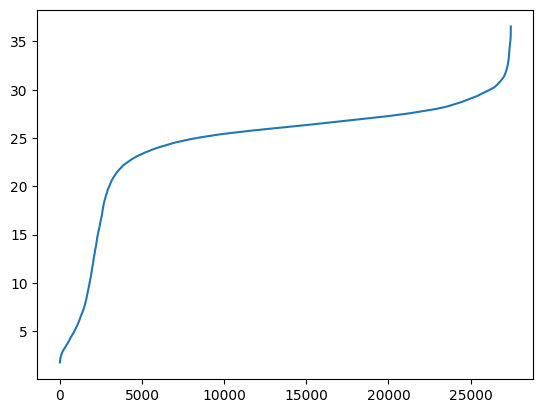

In [82]:
plt.plot(x, all_dists)

In [84]:
keys, cdf = get_cdf(all_dists)

Text(0, 0.5, '(%) Distances')

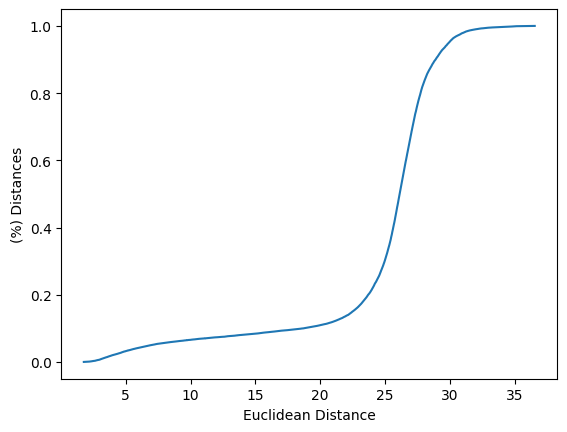

In [116]:
plt.plot(keys, cdf)
plt.xlabel("Euclidean Distance")
plt.ylabel("(%) Distances")

In [5]:
meta_layer = "10_folds/logistic_regression/normal_probas"
dataset = "acm"

In [6]:
stats = {}

max_fixes = 0
for fold in np.arange(10):
    
    stats[fold] = {}

    y_train, y_test = load_y(LABELS_DIR_VAL, dataset, fold)
    probas = load_probs(PROBS_DIR, dataset, CLFS, fold)
    X_train, X_test = load_reps("", dataset, "bert_reps", fold)
    upper = load_upper(UPPER_DIR, dataset, CLFS, fold)
    model = load(f"{STACKING_DIR}/{dataset}/{meta_layer}/{clfs_stack}/fold_{fold}/model.joblib")
    centroids = []
    for c in set(y_train):
        centroids.append(np.mean(X_train[y_train == c], axis=0))
    centroids = np.vstack(centroids)
    
    dists = euclidean_distances(X_test, centroids)
    
    for interval in np.arange(10):
        X_test = fix_probas(CLFS, probas, upper, dists, interval)
        y_pred = model.predict(X_test)
        stats[fold][interval] = f1_score(y_test, y_pred, average="macro")

/home/welton/project/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
mean_intervals = { interval: 0 for interval in np.arange(10) }
for interval in mean_intervals:
    for fold in np.arange(10):
        mean_intervals[interval] += stats[fold][interval] / 10

In [9]:
mean_intervals

{0: 0.7390976807930711,
 1: 0.7438402947627327,
 2: 0.7431347840573369,
 3: 0.7436498004781386,
 4: 0.7403584134175134,
 5: 0.740313757525746,
 6: 0.732196766774852,
 7: 0.7316019225379503,
 8: 0.7340182696928751,
 9: 0.741828638627035}